In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Solving Convection (Linear Advection) Problem

The problem is given by: 
$$
    \frac{\partial u}{\partial t} + \beta \frac{\partial u}{\partial x} = 0
    \qquad
    x \in [0,M], \, t \in [0,T]
$$
With initial condition: 
$$
    u(x,0) = h(x)
    \qquad
    x \in [0,M]
$$
and periodic boundary condition: 
$$
    u(0,t) = u(M,t)
    \qquad
    t \in [0,T]
$$

Here we focus on a specific instance where $\beta = 50$, $M = 2\pi$, $T = 1$, and $h(x) = \sin(x)$.

## Reference solution from PINNsFormer

The solution is provided as a MATLAB MAT-file in the published [demo](https://github.com/AdityaLab/pinnsformer/tree/main/demo/convection).

The original paper does not give details on how the solution is obtained. Here we note that the built-in MATLAB PDE solver `pdepe` and other simialr functions in the PDE Toollbox do not natively support periodic boundary conditions. We suspect the authors either used some custom numerical scheme or implemented work-around to get the result. 

In [2]:
u_mat = loadmat('convection.mat')['u']

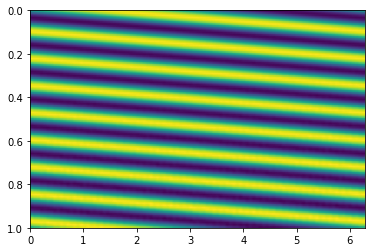

In [3]:
plt.imshow(u_mat, extent=[0,np.pi*2,1,0], aspect='auto')

## Reference solution from PINNs Failure Modes

The numerical scheme can be found in the published [code](https://github.com/a1k12/characterizing-pinns-failure-modes/blob/main/pbc_examples/systems_pbc.py).

The original implementation is for a more general convection-diffusion problems. We removed the unrelevant part and only kept the code necessary for the convection problem. 

The scheme generally follows the stated analytical solution in the paper: 
$$
    u(x,t) = \mathcal{F}^{-1}\big((\mathcal{F}h)(\xi) \cdot \exp(-i \beta \xi t)\big)(x)
$$

In [4]:
def ft_solver(num_x, num_t, beta):

    h = 2 * np.pi / num_x
    x = np.arange(0, 2 * np.pi, h) # not inclusive of the last point
    t = np.linspace(0, 1, num_t).reshape(-1, 1)
    X, T = np.meshgrid(x, t)

    # call u0 this way so array is (n, ), so each row of u should also be (n, )
    u0 = np.sin(x)

    IKX_pos = 1j * np.arange(0, np.floor(num_x/2)+1, 1)
    IKX_neg = 1j * np.arange(-np.ceil(num_x/2)+1, 0, 1)
    IKX = np.concatenate((IKX_pos, IKX_neg))

    uhat0 = np.fft.fft(u0)
    factor = np.exp(-beta * IKX * T)
    u = np.real(np.fft.ifft(uhat0 * factor))

    return u

u_ft = ft_solver(101, 101, 50)

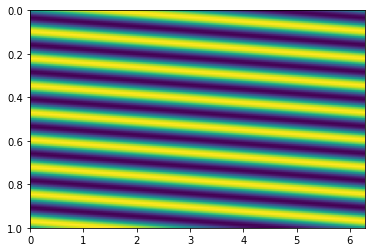

In [5]:
plt.imshow(u_ft, extent=[0,np.pi*2,1,0], aspect='auto')

## Lax-Wendroff Scheme

We use finite difference method and perform time-marching. To satisfy CFL condition, we need to control time step size (`num_t`). 

In [6]:
def lax_wendroff(num_x, num_t, beta):
    M = 2 * np.pi
    T = 1
    
    delta_x = M / (num_x + 0)
    delta_t = T / (num_t - 1)
    labda = delta_t / delta_x
    alpha = beta * labda
    # check CFL condition
    idx = np.arange(0, num_t, 1)
    if alpha >= 1: 
        # need to choose a smaller time step size
        num_t = int(2 * np.ceil(alpha) * (num_t - 1) + 1)
        idx = np.arange(0, num_t, 2 * np.ceil(alpha))
        delta_t = T / (num_t - 1)
        labda = delta_t / delta_x
        alpha = beta * labda
    
    # form matrix
    p = 1 - alpha ** 2
    q1 = 0.5 * alpha * (alpha + 1)
    q2 = 0.5 * alpha * (alpha - 1)
    A = p * np.identity(num_x) + np.diag(q1 * np.ones(num_x-1), -1) + np.diag(q2 * np.ones(num_x-1), 1)
    # apply boundary condition
    A[0,-1] = q1
    A[-1,0] = q2
    
    # apply initial condition
    U = np.sin(np.linspace(0, M, num_x))
    U_hist = [U]
    
    # perform time-marching
    for i in range(1, num_t):
        U = A @ U
        if i in idx: U_hist.append(U)
    
    return U_hist

u_fd = lax_wendroff(101, 101, 50)

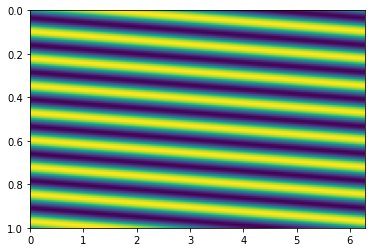

In [7]:
plt.imshow(u_fd, extent=[0,np.pi*2,1,0], aspect='auto')

## Analytical Solution

It turns out the analytical solution we saw earlier can be simplified. Using the Fourier Inversion Theorem, we can compute its simplified form: 
$$
    u(x,t) = h(x - beta \cdot t)
$$
We also note that the linear advection is exactly the transport equation. 

In [8]:
num_x = 101
num_t = 101
beta = 50
x = np.linspace(0, 2 * np.pi, num_x)
t = np.linspace(0, 1, num_t)
X,T = np.meshgrid(x,t)

u_analytical = np.sin(X - beta * T)

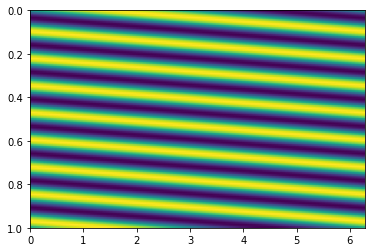

In [9]:
plt.imshow(u_analytical, extent=[0,np.pi*2,1,0], aspect='auto')

## Comparison

We know the accuracy of the Lax Wendroff is $\mathcal{O}(\Delta x^2 + \Delta t^2)$.

In [10]:
err_mat_ft = np.max(np.abs(u_mat - u_ft))
err_mat_fd = np.max(np.abs(u_mat - u_fd))
err_mat_ana = np.max(np.abs(u_mat - u_analytical))
err_ft_fd = np.max(np.abs(u_ft - u_fd))
err_ft_ana = np.max(np.abs(u_ft - u_analytical))
err_fd_ana = np.max(np.abs(u_fd - u_analytical))

print(f'PINNsFormer vs. FT, FD, analytical: {err_mat_ft}, {err_mat_fd}, {err_mat_ana}')
print(f'FT vs. FD, analytical: {err_ft_fd}, {err_ft_ana}')
print(f'FD vs. analytical: {err_fd_ana}')

PINNsFormer vs. FT, FD, analytical: 0.10375844406138264, 0.07676730932946174, 0.04731472853889285
FT vs. FD, analytical: 0.07108630384637982, 0.062178026934003074
FD vs. analytical: 0.06849164988059508


Errors of these methods (computed as the maximum absolute difference of the solution on the grid). 

|                   | Unknown MAT | Fourier | Finite Difference | Analytical |
| ----------------- | ----------- | ------- | ----------------- | ---------- |
| Unknown MAT       |             | 0.104   | 0.077             | 0.047      |
| Fourier           | 0.104       |         | 0.071             | 0.062      |
| Finite Difference | 0.077       | 0.071   |                   | 0.068      |
| Analytical        | 0.047       | 0.062   | 0.068             |            |